## Data Analysis using BulkLMM - BXD Longevity Study

In [1]:
using CSV, DelimitedFiles, DataFrames, Missings, XLSX
using LinearAlgebra, Statistics, Optim
using Random, Distributions, LoopVectorization
using GeneNetworkAPI, Downloads
using BenchmarkTools

In [2]:
local_path = "../../BulkLMM.jl/src";

#### Marker of interest
- Sdhaf4: on Chr1 at 24 Mb
- Ndufv1: on Chr1 at 22 Mb

#### Phenotype Datasets:
1. Chow diet (BXD mean)
2. High fat diet (BXD mean)
3. Both combined  (BXD mean)
4. Individual BXD (which obviously is both diets and all ages)


#### Data Set: EPFL/ETHZ BXD Liver Proteome CD-HFD (Nov19)

4 age groups, 2 treatments, 1 sex.

### Load datasets:

In [ ]:
pwd()

In [ ]:
datafolder_path = "data/";

#### Individual measurements of all liver proteome:

In [ ]:
lp_file_path = joinpath(datafolder_path, "GN886-Liver-Proteome-Individuals.txt"); # from Zach

In [ ]:
lp_ind = readdlm(lp_file_path, '\t');

In [ ]:
size(lp_ind)

In [ ]:
any(ismissing.(lp_ind))

In [ ]:
sum(ismissing.(lp_ind))

In [ ]:
lp_ind[1:10, 1:10]

In [ ]:
lp_ind_df = DataFrame(lp_ind[2:end, 1:end], lp_ind[1, 1:end]);

In [ ]:
lp_ind_df

In [ ]:
lp_ind[1:10, 1:10]

We see that the column names are the sample ids and the row names are the proteomic names.

For this demo we focus on the first liver proteomic, named as "`P42209_DESGLNRK_2`"

In [ ]:
strains_info_path = joinpath(datafolder_path, "P42209_DESGLNRK_2.xlsx");
xf = XLSX.readxlsx(strains_info_path)[1][:];

In [ ]:
strains_info = DataFrame(xf[9:end, :], xf[8, :]);

In [ ]:
strains_info

Extract the two columns containing information about the sample id and which strain the sample is drawn from:

In [ ]:
sub_strains_info = DataFrame(Sample = strains_info[:, :Name], Strain = strains_info[:, :Strain])

Then, filter out those samples that are not from BxD strains:

In [ ]:
is_from_BXD = occursin.(r"BXD*", sub_strains_info.Strain);
samples_from_BXD = sub_strains_info[is_from_BXD, :]

In [ ]:
lp_ind[1:2, 157]

In [ ]:
lp_dataframe = DataFrame(Sample = lp_ind[1, 2:end], Proteomic = lp_ind[2, 2:end])

In [ ]:
lp_dataframe.Sample

In [ ]:
BXD_strains_info = strains_info[is_from_BXD, :]

In [ ]:
sum(occursin.(r"b", BXD_strains_info.Strain))

remove those BXD strains with names ended with "a", or "b"

In [ ]:
toKeep = findall(x -> x == 0, occursin.(r"a|b", samples_from_BXD.Strain));

In [ ]:
samples_from_BXD_clean = samples_from_BXD[toKeep, :]

In [ ]:
BXD_pheno_clean = innerjoin(lp_dataframe, samples_from_BXD_clean, on = :Sample )

In [ ]:
BXD_pheno_clean.Strain_num = parse.(Int64, SubString.(BXD_pheno_clean.Strain, 4));
sort!(BXD_pheno_clean, [:Strain_num])

In [ ]:
C = 0.5*ones(3, 3) .+ diagm(0.5*ones(3));

In [ ]:
cluster = ones(3, 3)

In [ ]:
kron(C, cluster)

Kronecker product only works for balanced samples?

In [ ]:
datafolder_path

In [ ]:
BXD_geno_full = readdlm(joinpath(datafolder_path, "../BXD_Geno_Dec_2018_GN-unix.txt"), '\t');

In [ ]:
unique(BXD_pheno_clean.Strain)

In [ ]:
unique(BXD_geno_full[22, :])

In [ ]:
BXD_geno_full[22:end, (end-8)]

In [ ]:
BXD_gmap = BXD_geno_full[22:end, 1:5];
# gmap contains information about the loci (chromosome, cM, Mb).
BXD_gmap_df = DataFrame(BXD_gmap[2:end, :], BXD_gmap[1, :]);
BXD_gmap_df[1:10, :]

In [ ]:
BXD_geno = permutedims(BXD_geno_full[22:end, 6:(end-8)]);
replace!(BXD_geno, "B" => 0.0, "H" => 0.5, "D" => 1.0)
println(size(BXD_geno));
BXD_geno[:, 1:10] # contains genotypes on 7321 markers of 198 BXD strains

In [ ]:
BXD_geno_df = DataFrame(BXD_geno, vcat("Strain", BXD_gmap_df.Locus));
# BXD_geno_df contains information about the genotype probabality 
# at each locus of each strain
println(size(BXD_geno_df))
BXD_geno_df[1:10, 1:10] 

In [ ]:
BXD_pheno_clean

Then, we extract the BXD's corresponding to our samples...

In [ ]:
BXD_summary_df = innerjoin(BXD_pheno_clean, BXD_geno_df; on = :Strain);

In [ ]:
a = [1, 2, 3];
b = [1, 2, 3];

In [ ]:
function test_repeat(x, r)
    return repeat(x, r);
end

In [ ]:
reduce(vcat, map((x, r) -> test_repeat([x], r), a, b))

In [ ]:
map(x -> test_repeat(a, x), b)

In [ ]:
BXD_summary_df

In [ ]:
BXD_geno_summary_df = BXD_summary_df[:, Not("Proteomic")]

In [ ]:
BXD_pheno_all_df = DataFrame(BXD_lp_ind_all, BXD_lp_ind_all_names)

In [ ]:
BXD_pheno_summary_df = hcat(BXD_summary_df[:, [:Sample, :Strain, :Strain_num]], BXD_pheno_all_df) 

In [ ]:
BXD_geno_summary_df

In [ ]:
lp_ind_df[:, BXD_summary_df.Sample];

In [ ]:
BXD_lp_ind_all = Matrix{Float64}(lp_ind_df[:, BXD_summary_df.Sample]) |> permutedims;

In [ ]:
size(BXD_lp_ind_all)

In [ ]:
BXD_lp_ind_all_names = lp_ind_df[:, 1];

In [ ]:
pwd()

In [26]:
# summary_file = joinpath(datafolder_path, "LP_P42209_Individuals_BXD_summary.csv")

# CSV.write(summary_file, BXD_summary_df)

# CSV.write("data/GN886_geno_summary.csv", BXD_geno_summary_df);
# CSV.write("data/GN886_pheno_summary.csv", BXD_pheno_summary_df);

### Load functions:

In [ ]:
pwd()

In [3]:
include(joinpath(local_path, "kinship.jl"));
include(joinpath(local_path, "util.jl"));
include(joinpath(local_path, "wls.jl"));
include(joinpath(local_path, "lmm.jl"));
include(joinpath(local_path, "transform_helpers.jl"));
include(joinpath(local_path, "scan.jl"));
include(joinpath(local_path, "bulkscan_helpers.jl"));
include(joinpath(local_path, "bulkscan.jl"));

In [ ]:
# using BulkLMM

https://genenetwork.org/api/v_pre1/sample_data/EPFL-ETHZ-BXD-LivProtCD-HF-1119

## Analysis Starts:

In [8]:
pwd()

"/home/zyu20/git/BulkLMM_Analyses/BXDLongevity"

In [27]:
BXD_geno_summary_df = CSV.read("data/GN886_geno_summary.csv", DataFrame);

In [28]:
BXD_pheno_summary_df = CSV.read("data/GN886_pheno_summary.csv", DataFrame);

### Calculate kinship:

In [29]:
size(BXD_geno_summary_df) # contains 248 samples and 7321 markers

(248, 7324)

In [30]:
size(BXD_pheno_summary_df) # contains 248 samples and 32445 liver proteome

(248, 32448)

In [31]:
BXD_pheno_summary_df[1:10, 1:10]

Row,Sample,Strain,Strain_num,P42209_DESGLNRK_2,P42209_GLRPLDVAFLR_3,Q99M02_VGDPVYR_2,Q99M02_VWIYPIK_2,Q99M02_LCDPSVK_2,Q99M02_CVLTTVDPDTGIIDR_2,Q99M02_LVQFDTSMK_2
,String7,String7,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,H1009,BXD9,9,11.349,11.534,17.587,17.517,17.309,16.574,16.323
2,H0370,BXD9,9,11.249,12.735,17.427,17.325,17.252,16.685,16.021
3,H2577,BXD9,9,12.415,10.487,17.89,17.488,17.594,16.731,16.208
4,H0365,BXD9,9,11.374,10.674,17.714,17.401,17.381,16.621,16.337
5,H1333,BXD13,13,11.687,11.524,17.362,17.367,17.071,16.465,15.97
6,H2259,BXD24,24,11.837,11.715,17.57,17.792,17.505,16.894,16.277
7,H1792,BXD24,24,11.563,11.434,17.789,17.847,17.416,17.042,16.292
8,H1791,BXD24,24,12.5,12.273,17.944,17.833,17.63,16.862,16.3
9,H1541,BXD24,24,11.815,11.564,17.794,17.759,17.456,16.878,16.377


Check that innerjoin() automatically duplicated the `genoprobs` for each strain...

In [32]:
# Test trial: "H" or "D" for the BXD24
HD_alleles = findall(x -> (x == 0.5)|(x == 1.0), BXD_geno_summary_df[6, 1:end]);
BXD_geno_summary_df[6:10, HD_alleles]

Row,rs31612855,rs236370277,rs30205785,rs13475954,rs32668634,rs13475957,rs32358097,rs3678377,rs30804641,rs31929413,rs219816352,rs50310397,rs32104666,rs51130709,rs13475967,rs48766014,rs6234856,rs46281379,rs47858597,rs30307999,rs13475970,rs30341693,rs30337529,rs30330393,rs50175543,rs45885174,rs52508722,rs13475979,rs13475980,rs33082518,rs32252974,rs33069894,rs32182636,rs13475984,rs30390109,rs3692309,rs3713135,rs4137444,rs32234269,rs31144348,rs32199840,rs13475991,rs31707646,rs30558618,rs13476003,rs13476004,rs30442897,rs13476006,rs31666743,rs32261404,rs37486156,rs36618375,rs13476012,rs30966514,rs51210174,rs13476025,rs31806216,rs13476030,rs32565357,rs32697536,rs30506144,rs30488981,rs30487561,rs30484039,rs47647099,rs49762567,rs3680216,rs31994637,rs31960226,rs32738873,rs31744083,rs47329570,rs31960159,rs13476045,rs45843892,rs31935680,rs3685919,rs6319405,rs3710646,rs30584583,rs51800183,rs48823920,rs30719160,rs31471077,rs30675648,rs32180662,rs30680977,rs32807094,rs30637341,rs32757674,rs32268077,rs30725178,rs30724278,rs30698282,rs3723088,rs3663708,rs31007558,rs30727085,rs48015801,rs230640887,⋯
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,⋯
1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,⋯
2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,⋯
3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,⋯
4,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,⋯
5,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,⋯


In [33]:
any(x -> ismissing(x), Matrix(BXD_pheno_summary_df)) # no missings in the data

false

In [34]:
test_dict = Dict{Int, Int}()

Dict{Int64, Int64}()

In [35]:
test_dict[1] = 1

1

In [36]:
haskey(test_dict, 1)

true

In [37]:
BXD_geno_summary_df.Strain_num = convert.(Int64, BXD_geno_summary_df.Strain_num);

In [38]:
function calcRepeats(x::Array{Int64, 1})
    
    counting_dict = Dict{Int64, Int64}();
    
    for i in 1:length(x)
        curr_key = x[i];
        if haskey(counting_dict, curr_key) # if current key already exists
            counting_dict[curr_key] += 1;
        else # if current key does not present, add it as a new key
            counting_dict[curr_key] = 1;
        end
    end
    
    return counting_dict
    
end

calcRepeats (generic function with 1 method)

In [39]:
counting_dict = calcRepeats(BXD_geno_summary_df.Strain_num);
counting_dict_sorted = sort(collect(counting_dict), by = x -> x[1])[1:10] # show to verify what we observed

10-element Vector{Pair{Int64, Int64}}:
  9 => 4
 13 => 1
 24 => 5
 27 => 3
 29 => 11
 32 => 8
 34 => 13
 39 => 5
 40 => 8
 43 => 4

In [40]:
geno_ind = Matrix{Float64}(BXD_geno_summary_df[:, 4:end]);

In [41]:
geno_ind

248×7321 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     1.0  1.0  1.0  1.0  1.0  1.0  1.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     1.0  1.0  1.0  1.0  1.0  1.0  1.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     1.0  1.0  1.0  1.0  1.0  1.0  1.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     1.0  1.0  1.0  1.0  1.0  1.0  1.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     1.0  1.0  1.0  1.0  1.0  1.0  1.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     1.0  1.0  1.0  1.0  1.0  1.0  1.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.

In [42]:
pheno_ind = Vector{Float64}(BXD_pheno_summary_df[:, 4]);
pheno_ind = reshape(pheno_ind, :, 1);

In [43]:
# for comparison...
@time kinship_ind_from_ind = calcKinship(geno_ind);

  3.203059 seconds (306.28 k allocations: 8.368 GiB, 5.21% gc time)


In [161]:
@time lp1_scan_ind = scan(pheno_ind, geno_ind, kinship_ind_from_strains);

  0.385817 seconds (80.94 k allocations: 134.905 MiB, 50.71% gc time)


In [162]:
lp1_scan_ind.h2_null

0.10913190745368709

In [163]:
lp1_scan_ind.lod

7321-element Vector{Float64}:
 0.8875218954533199
 0.8875218954533199
 0.8875218954533199
 0.8875218954533199
 0.8875218954533199
 0.8875218954533199
 0.8875218954533199
 0.8875218954533199
 0.8875218954533199
 0.8875218954533199
 0.8875218954533199
 0.8875218954533199
 0.3781861413995955
 ⋮
 0.28711569587487595
 0.28711569587487595
 0.28711569587487595
 0.6986386009598515
 0.8090988229723184
 0.8090988229723184
 0.5954586583365433
 0.44927456705495317
 0.5954586583365433
 0.44927456705495317
 0.20568165232305446
 0.20568165232305446

In [47]:
@time lp1_scan_perms_ind = scan(pheno_ind, geno_ind, kinship_ind_from_ind; 
                                permutation_test = true, nperms = 1000, original = true);

  1.092741 seconds (1.91 M allocations: 259.557 MiB, 17.03% gc time, 72.21% compilation time)


In [48]:
lp1_scan_perms_ind[:, 1]

7321-element Vector{Float64}:
 0.8889441174155365
 0.8889441174155365
 0.8889441174155365
 0.8889441174155365
 0.8889441174155365
 0.8889441174155365
 0.8889441174155365
 0.8889441174155365
 0.8889441174155365
 0.8889441174155365
 0.8889441174155365
 0.8889441174155365
 0.3783129989229251
 ⋮
 0.2876839657716031
 0.2876839657716031
 0.2876839657716031
 0.6993094665947388
 0.8098417987679631
 0.8098417987679631
 0.5961186116044899
 0.4493923262523157
 0.5961186116044899
 0.4493923262523157
 0.2057090226890375
 0.2057090226890375

In [49]:
max_lods_ind = vec(mapslices(x -> maximum(x), lp1_scan_perms_ind; dims = 1));
thrs_ind = map(x -> quantile(max_lods_ind, x), [0.85, 0.95])

2-element Vector{Float64}:
 2.996466781550206
 3.464540168611259

In [79]:
gdf = groupby(BXD_pheno_summary_df, :Strain)
group_means = map(x -> mean.(eachcol(gdf[x][:, 4:end])), 1:length(gdf));
BXD_strain_means = permutedims(reduce(hcat, group_means))
# BXD_strain_means;
BXD_strains = unique(BXD_geno_summary_df.Strain_num);

In [80]:
BXD_strains

50-element Vector{Int64}:
   9
  13
  24
  27
  29
  32
  34
  39
  40
  43
  44
  45
  48
   ⋮
  86
  87
  88
  89
  90
  91
  95
  98
  99
 100
 101
 102

In [72]:
BXD_strain_means; # strain means of all 32k liver proteome

In [83]:
@time matched_strains = indexin(BXD_strains, BXD_geno_summary_df.Strain_num);

  0.035973 seconds (88.88 k allocations: 4.696 MiB, 99.90% compilation time)


In [90]:
BXD_geno_summary_df[matched_strains, :];
geno_strains = Matrix{Float64}(BXD_geno_summary_df[matched_strains, 4:end]);
println(size(geno_strains));
geno_strains

(50, 7321)


50×7321 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     1.0  1.0  1.0  1.0  1.0  1.0  1.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     1.0  1.0  1.0  1.0  1.0  1.0  1.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     1.0  1.0  1.0  1.0  1.0  1.0  1.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0

In [93]:
pheno_strains = reshape(BXD_strain_means[:, 1], :, 1) # strain means as phenotypes;

In [94]:
@time kinship_strains = calcKinship(geno_strains);

  0.338040 seconds (44.19 k allocations: 343.225 MiB, 55.60% gc time)


In [95]:
@time lp1_scan_strains = scan(pheno_strains, geno_strains, kinship_strains);

  0.038524 seconds (82.15 k allocations: 32.632 MiB)


In [96]:
size(pheno_strains)

(50, 1)

In [97]:
scan_perms_lite(pheno_strains, geno_strains, ones(50, 1), kinship_strains; addIntercept = false, nperms = 1000, original = true)

7321×1001 Matrix{Float64}:
 0.545307  0.00444317  0.00659084  …  0.053768   0.752888   0.460921
 0.545307  0.00444317  0.00659084     0.053768   0.752888   0.460921
 0.545307  0.00444317  0.00659084     0.053768   0.752888   0.460921
 0.545307  0.00444317  0.00659084     0.053768   0.752888   0.460921
 0.545307  0.00444317  0.00659084     0.053768   0.752888   0.460921
 0.545307  0.00444317  0.00659084  …  0.053768   0.752888   0.460921
 0.545307  0.00444317  0.00659084     0.053768   0.752888   0.460921
 0.545307  0.00444317  0.00659084     0.053768   0.752888   0.460921
 0.545307  0.00444317  0.00659084     0.053768   0.752888   0.460921
 0.545307  0.00444317  0.00659084     0.053768   0.752888   0.460921
 0.545307  0.00444317  0.00659084  …  0.053768   0.752888   0.460921
 0.545307  0.00444317  0.00659084     0.053768   0.752888   0.460921
 0.241439  0.172432    0.0464333      0.0236831  0.285401   0.163433
 ⋮                                 ⋱                        ⋮
 0.530659  0.4

In [98]:
@time lp1_scan_perms_strains = scan(pheno_strains, geno_strains, kinship_strains;
                                    permutation_test = true, nperms = 1000, original = true);

  0.038316 seconds (91.29 k allocations: 79.023 MiB)


In [99]:
lp1_scan_strains.lod

7321-element Vector{Float64}:
 0.5453068164475078
 0.5453068164475078
 0.5453068164475078
 0.5453068164475078
 0.5453068164475078
 0.5453068164475078
 0.5453068164475078
 0.5453068164475078
 0.5453068164475078
 0.5453068164475078
 0.5453068164475078
 0.5453068164475078
 0.24143899094207222
 ⋮
 0.5306593784727226
 0.5306593784727226
 0.5306593784727226
 0.9283185679920841
 1.0004165902948559
 1.0004165902948559
 0.8190831270960958
 0.49265479079828867
 0.8190831270960958
 0.49265479079828867
 0.12567381412006418
 0.12567381412006418

In [100]:
lp1_scan_perms_strains

7321×1001 Matrix{Float64}:
 0.545307  0.00444317  0.00659084  …  0.053768   0.752888   0.460921
 0.545307  0.00444317  0.00659084     0.053768   0.752888   0.460921
 0.545307  0.00444317  0.00659084     0.053768   0.752888   0.460921
 0.545307  0.00444317  0.00659084     0.053768   0.752888   0.460921
 0.545307  0.00444317  0.00659084     0.053768   0.752888   0.460921
 0.545307  0.00444317  0.00659084  …  0.053768   0.752888   0.460921
 0.545307  0.00444317  0.00659084     0.053768   0.752888   0.460921
 0.545307  0.00444317  0.00659084     0.053768   0.752888   0.460921
 0.545307  0.00444317  0.00659084     0.053768   0.752888   0.460921
 0.545307  0.00444317  0.00659084     0.053768   0.752888   0.460921
 0.545307  0.00444317  0.00659084  …  0.053768   0.752888   0.460921
 0.545307  0.00444317  0.00659084     0.053768   0.752888   0.460921
 0.241439  0.172432    0.0464333      0.0236831  0.285401   0.163433
 ⋮                                 ⋱                        ⋮
 0.530659  0.4

In [101]:
hcat(lp1_scan_strains.lod, lp1_scan_perms_strains[:, 1])

7321×2 Matrix{Float64}:
 0.545307  0.545307
 0.545307  0.545307
 0.545307  0.545307
 0.545307  0.545307
 0.545307  0.545307
 0.545307  0.545307
 0.545307  0.545307
 0.545307  0.545307
 0.545307  0.545307
 0.545307  0.545307
 0.545307  0.545307
 0.545307  0.545307
 0.241439  0.241439
 ⋮         
 0.530659  0.530659
 0.530659  0.530659
 0.530659  0.530659
 0.928319  0.928319
 1.00042   1.00042
 1.00042   1.00042
 0.819083  0.819083
 0.492655  0.492655
 0.819083  0.819083
 0.492655  0.492655
 0.125674  0.125674
 0.125674  0.125674

In [102]:
lp1_scan_perms_ind

7321×1001 Matrix{Float64}:
 0.888944  0.0595824   0.0423303  …  0.0144366    0.291319   0.725278
 0.888944  0.0595824   0.0423303     0.0144366    0.291319   0.725278
 0.888944  0.0595824   0.0423303     0.0144366    0.291319   0.725278
 0.888944  0.0595824   0.0423303     0.0144366    0.291319   0.725278
 0.888944  0.0595824   0.0423303     0.0144366    0.291319   0.725278
 0.888944  0.0595824   0.0423303  …  0.0144366    0.291319   0.725278
 0.888944  0.0595824   0.0423303     0.0144366    0.291319   0.725278
 0.888944  0.0595824   0.0423303     0.0144366    0.291319   0.725278
 0.888944  0.0595824   0.0423303     0.0144366    0.291319   0.725278
 0.888944  0.0595824   0.0423303     0.0144366    0.291319   0.725278
 0.888944  0.0595824   0.0423303  …  0.0144366    0.291319   0.725278
 0.888944  0.0595824   0.0423303     0.0144366    0.291319   0.725278
 0.378313  0.085462    0.0757599     0.000457973  0.15034    0.719579
 ⋮                                ⋱                          ⋮


In [103]:
lp1_scan_ind.lod

7321-element Vector{Float64}:
 0.8889441174155017
 0.8889441174155017
 0.8889441174155017
 0.8889441174155017
 0.8889441174155017
 0.8889441174155017
 0.8889441174155017
 0.8889441174155017
 0.8889441174155017
 0.8889441174155017
 0.8889441174155017
 0.8889441174155017
 0.3783129989229099
 ⋮
 0.2876839657715564
 0.2876839657715564
 0.2876839657715564
 0.6993094665947233
 0.809841798767966
 0.809841798767966
 0.5961186116044814
 0.44939232625229764
 0.5961186116044814
 0.44939232625229764
 0.2057090226890388
 0.2057090226890388

In [104]:
hcat(lp1_scan_ind.lod, lp1_scan_perms_ind[:, 1])

7321×2 Matrix{Float64}:
 0.888944  0.888944
 0.888944  0.888944
 0.888944  0.888944
 0.888944  0.888944
 0.888944  0.888944
 0.888944  0.888944
 0.888944  0.888944
 0.888944  0.888944
 0.888944  0.888944
 0.888944  0.888944
 0.888944  0.888944
 0.888944  0.888944
 0.378313  0.378313
 ⋮         
 0.287684  0.287684
 0.287684  0.287684
 0.287684  0.287684
 0.699309  0.699309
 0.809842  0.809842
 0.809842  0.809842
 0.596119  0.596119
 0.449392  0.449392
 0.596119  0.596119
 0.449392  0.449392
 0.205709  0.205709
 0.205709  0.205709

In [105]:
max_lods_strains = vec(mapslices(x -> maximum(x), lp1_scan_perms_strains; dims = 1));
thrs_strains = map(x -> quantile(max_lods_strains, x), [0.85, 0.95])

2-element Vector{Float64}:
 3.1879729539760038
 3.7182035207562705

In [106]:
hcat(thrs_strains, thrs_ind)

2×2 Matrix{Float64}:
 3.18797  2.99647
 3.7182   3.46454

In [107]:
using Plots

In [108]:
lp1_scan_strains.h2_null

3.324562949461316e-16

In [109]:
lp1_scan_ind.h2_null

0.1088690292684586

In [110]:
scatter(lp1_scan_strains.lod, lp1_scan_ind.lod, color = "red")# , label = "individuals");
plot!(x -> x, 0, 4, color = "blue")
# scatter!(lp1_scan_strains.lod, color = "green", label = "strains");

In [111]:
scatter(lp1_scan_ind.lod, color = "red", label = "individuals");
scatter!(lp1_scan_strains.lod, color = "green", label = "strains");
hline!(thrs_strains, label = "", color = "blue")

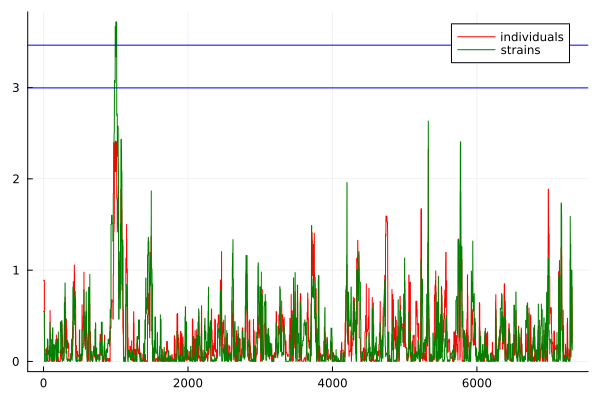

In [112]:
plot(lp1_scan_ind.lod, color = "red", label = "individuals");
plot!(lp1_scan_strains.lod, color = "green", label = "strains");
hline!(thrs_ind, label = "", color = "blue")

In [113]:
lp1_scan_ind.h2_null # individuals

0.1088690292684586

In [114]:
lp1_scan_strains.h2_null # strain means

3.324562949461316e-16

In [115]:
counting_dict

Dict{Int64, Int64} with 50 entries:
  56 => 1
  55 => 1
  60 => 3
  32 => 8
  67 => 2
  45 => 5
  73 => 7
  64 => 3
  90 => 6
  13 => 1
  63 => 12
  86 => 4
  91 => 2
  62 => 5
  75 => 2
  43 => 4
  69 => 5
  68 => 2
  98 => 5
  39 => 5
  84 => 2
  77 => 6
  95 => 5
  66 => 5
  34 => 13
  ⋮  => ⋮

In [122]:
reps_each_strain = map(x -> counting_dict[x], unique(BXD_geno_summary_df.Strain_num));
geno_strains

50×7321 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     1.0  1.0  1.0  1.0  1.0  1.0  1.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     1.0  1.0  1.0  1.0  1.0  1.0  1.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     1.0  1.0  1.0  1.0  1.0  1.0  1.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0

In [123]:
kinship_strains[1, 1]

1.0

In [124]:
BXD_geno_summary_df[1:10, 1:10]

Row,Sample,Strain,Strain_num,rs31443144,rs6269442,rs32285189,rs258367496,rs32430919,rs36251697,rs30658298
,String7,String7,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,H1009,BXD9,9,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,H0370,BXD9,9,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,H2577,BXD9,9,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,H0365,BXD9,9,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,H1333,BXD13,13,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,H2259,BXD24,24,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,H1792,BXD24,24,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,H1791,BXD24,24,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,H1541,BXD24,24,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [125]:
@btime combine(groupby(BXD_geno_summary_df[:, [:Sample, :Strain]], :Strain), nrow => :count);

  65.073 μs (281 allocations: 23.84 KiB)


In [127]:
@btime calcRepeats(BXD_geno_summary_df.Strain_num);

  6.503 μs (10 allocations: 6.36 KiB)


In [131]:
function calcIndKinship_from_StrainKinship(kinship_strains::Array{Float64, 2}, 
                                           strain_info_about_samples::Array{Int64, 1})
    
    counting_dict = calcRepeats(strain_info_about_samples);
    reps_each_strain = map(x -> counting_dict[x], unique(strain_info_about_samples));
    
    # Initialize the placeholder:
    kinship_ind_from_strains = ones(sum(reps_each_strain), sum(reps_each_strain));

    # process the first BXD strain...
    reps_strain_1 = reps_each_strain[1];
    k_11 = kinship_strains[1, 1];
    # block_11 = ones(reps_strain_1, reps_strain_1);

    row_id = 0;
    col_id = 0;

    @views kinship_ind_from_strains[(row_id+1):(row_id+reps_strain_1), 
                             (row_id+1):(row_id+reps_strain_1)] .*= k_11;

    for j in 2:length(reps_each_strain)
        reps_strain_j = reps_each_strain[j];
        k_1j = kinship_strains[1, j];
        # block_1j = ones(reps_strain_1, reps_strain_j);

        col_id += reps_each_strain[j-1];
        @views kinship_ind_from_strains[(row_id+1):(row_id+reps_strain_1), 
                                 (col_id+1):(col_id+reps_strain_j)] .*= k_1j;

        # process the off-diagonal block conveniently...
        # block_j1 = ones(reps_strain_j, reps_strain_1);
        kinship_ind_from_strains[(col_id+1):(col_id+reps_strain_j),
                                 (row_id+1):(row_id+reps_strain_1)] .*= k_1j;

    end

    # process for the second BXD strain and all after...
    # for i in 2:length(reps_each_strain)
    for i in 2:length(reps_each_strain)

        reps_strain_i = reps_each_strain[i];
        k_ii = kinship_strains[i, i];
        # block_ii = ones(reps_strain_i, reps_strain_i);

        row_id += reps_each_strain[i-1];
        @views kinship_ind_from_strains[(row_id+1):(row_id+reps_strain_i), 
                                 (row_id+1):(row_id+reps_strain_i)] .*= k_ii;

        col_id = row_id+reps_strain_i;

        for j in (i+1):length(reps_each_strain)

            reps_strain_j = reps_each_strain[j];
            k_ij = kinship_strains[i, j];
            # block_ij = ones(reps_strain_i, reps_strain_j);

            @views kinship_ind_from_strains[(row_id+1):(row_id+reps_strain_i), 
                                     (col_id+1):(col_id+reps_strain_j)] .*= k_ij;

            # process the off-diagonal block conveniently...
            # block_ji = ones(reps_strain_j, reps_strain_i);
            @views kinship_ind_from_strains[(col_id+1):(col_id+reps_strain_j),
                                     (row_id+1):(row_id+reps_strain_i)] .*= k_ij;

            col_id += reps_each_strain[j];
        end
    
    end
    
    return kinship_ind_from_strains
end

calcIndKinship_from_StrainKinship (generic function with 1 method)

In [133]:
@time kinship_ind_from_strains = calcIndKinship_from_StrainKinship(kinship_strains, BXD_geno_summary_df.Strain_num);

  0.000251 seconds (76 allocations: 503.766 KiB)


In [134]:
# for comparison...
@time kinship_ind_from_ind = calcKinship(geno_ind);

  3.256864 seconds (306.28 k allocations: 8.368 GiB, 5.89% gc time)


In [136]:
kinship_ind_from_ind

248×248 Matrix{Float64}:
 1.0       0.998702  0.998702  0.998702  …  0.549925  0.549925  0.549925
 0.998702  1.0       0.998702  0.998702     0.549925  0.549925  0.549925
 0.998702  0.998702  1.0       0.998702     0.549925  0.549925  0.549925
 0.998702  0.998702  0.998702  1.0          0.549925  0.549925  0.549925
 0.554842  0.554842  0.554842  0.554842     0.531895  0.531895  0.531895
 0.583732  0.583732  0.583732  0.583732  …  0.540227  0.540227  0.540227
 0.583732  0.583732  0.583732  0.583732     0.540227  0.540227  0.540227
 0.583732  0.583732  0.583732  0.583732     0.540227  0.540227  0.540227
 0.583732  0.583732  0.583732  0.583732     0.540227  0.540227  0.540227
 0.583732  0.583732  0.583732  0.583732     0.540227  0.540227  0.540227
 0.529504  0.529504  0.529504  0.529504  …  0.557984  0.557984  0.557984
 0.529504  0.529504  0.529504  0.529504     0.557984  0.557984  0.557984
 0.529504  0.529504  0.529504  0.529504     0.557984  0.557984  0.557984
 ⋮                        

In [137]:
maximum(abs.(kinship_ind_from_strains .- kinship_ind_from_ind))

0.04186586531894554

In [139]:
size(kinship_ind_from_strains)

(248, 248)

In [140]:
size(kinship_ind_from_ind)

(248, 248)

### Multiple traits scans:

In [141]:
geno_ind

248×7321 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     1.0  1.0  1.0  1.0  1.0  1.0  1.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     1.0  1.0  1.0  1.0  1.0  1.0  1.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     1.0  1.0  1.0  1.0  1.0  1.0  1.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     1.0  1.0  1.0  1.0  1.0  1.0  1.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     1.0  1.0  1.0  1.0  1.0  1.0  1.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     1.0  1.0  1.0  1.0  1.0  1.0  1.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.

In [146]:
BXD_lp_ind_all = Matrix{Float64}(BXD_pheno_summary_df[:, 4:end]);

In [147]:
size(BXD_lp_ind_all)

(248, 32445)

In [167]:
BLAS.get_num_threads()

1

In [153]:
BLAS.set_num_threads(16)

In [152]:
@benchmark bulkscan_null_grid(BXD_lp_ind_all, geno_ind, kinship_ind_from_strains, collect(0.0:0.05:0.95))

BenchmarkTools.Trial: 1 sample with 1 evaluation.
 Single result which took 5.866 s (9.53% GC) to evaluate,
 with a memory estimate of 11.67 GiB, over 10097539 allocations.

In [151]:
@time lp_all_ind_grid = bulkscan_null_grid(BXD_lp_ind_all, geno_ind, kinship_ind_from_strains, collect(0.0:0.05:0.95))

  6.684461 seconds (10.10 M allocations: 11.669 GiB, 16.90% gc time)


7321×32445 Matrix{Float64}:
 0.903884  0.0906523   0.389302  …  0.0817255  0.247676   0.0039923
 0.903884  0.0906523   0.389302     0.0817255  0.247676   0.0039923
 0.903884  0.0906523   0.389302     0.0817255  0.247676   0.0039923
 0.903884  0.0906523   0.389302     0.0817255  0.247676   0.0039923
 0.903884  0.0906523   0.389302     0.0817255  0.247676   0.0039923
 0.903884  0.0906523   0.389302  …  0.0817255  0.247676   0.0039923
 0.903884  0.0906523   0.389302     0.0817255  0.247676   0.0039923
 0.903884  0.0906523   0.389302     0.0817255  0.247676   0.0039923
 0.903884  0.0906523   0.389302     0.0817255  0.247676   0.0039923
 0.903884  0.0906523   0.389302     0.0817255  0.247676   0.0039923
 0.903884  0.0906523   0.389302  …  0.0817255  0.247676   0.0039923
 0.903884  0.0906523   0.389302     0.0817255  0.247676   0.0039923
 0.382075  0.172607    0.296244     0.116461   0.0869291  0.080898
 ⋮                               ⋱                        
 0.291699  0.125481    0.34814

In [170]:
@time lp_all_ind_exact = bulkscan_null(BXD_lp_ind_all, geno_ind, kinship_ind_from_strains) # ; nb = 8, nt_blas = 8)

174.569481 seconds (2.60 G allocations: 1.813 TiB, 37.88% gc time)


7321×32445 Matrix{Float64}:
 0.887522  0.144298    0.390545   …  0.08139   0.247676   0.0039923
 0.887522  0.144298    0.390545      0.08139   0.247676   0.0039923
 0.887522  0.144298    0.390545      0.08139   0.247676   0.0039923
 0.887522  0.144298    0.390545      0.08139   0.247676   0.0039923
 0.887522  0.144298    0.390545      0.08139   0.247676   0.0039923
 0.887522  0.144298    0.390545   …  0.08139   0.247676   0.0039923
 0.887522  0.144298    0.390545      0.08139   0.247676   0.0039923
 0.887522  0.144298    0.390545      0.08139   0.247676   0.0039923
 0.887522  0.144298    0.390545      0.08139   0.247676   0.0039923
 0.887522  0.144298    0.390545      0.08139   0.247676   0.0039923
 0.887522  0.144298    0.390545   …  0.08139   0.247676   0.0039923
 0.887522  0.144298    0.390545      0.08139   0.247676   0.0039923
 0.378186  0.188714    0.298493      0.116344  0.0869291  0.080898
 ⋮                                ⋱                       
 0.287116  0.0726666   0.35964

In [160]:
@time lp_all_ind_grid_alt = bulkscan_alt_grid(BXD_lp_ind_all, geno_ind, kinship_ind_from_strains, 
                                              collect(0.0:0.05:0.95))

 28.004078 seconds (8.69 M allocations: 41.839 GiB, 28.05% gc time)


7321×32445 Matrix{Float64}:
 1.17957   0.171508   0.392375  0.206745  …  0.0824406  0.247676   0.0750931
 1.17957   0.171508   0.392375  0.206745     0.0824406  0.247676   0.0750931
 1.17957   0.171508   0.392375  0.206745     0.0824406  0.247676   0.0750931
 1.17957   0.171508   0.392375  0.206745     0.0824406  0.247676   0.0750931
 1.17957   0.171508   0.392375  0.206745     0.0824406  0.247676   0.0750931
 1.17957   0.171508   0.392375  0.206745  …  0.0824406  0.247676   0.0750931
 1.17957   0.171508   0.392375  0.206745     0.0824406  0.247676   0.0750931
 1.17957   0.171508   0.392375  0.206745     0.0824406  0.247676   0.0750931
 1.17957   0.171508   0.392375  0.206745     0.0824406  0.247676   0.0750931
 1.17957   0.171508   0.392375  0.206745     0.0824406  0.247676   0.0750931
 1.17957   0.171508   0.392375  0.206745  …  0.0824406  0.247676   0.0750931
 1.17957   0.171508   0.392375  0.206745     0.0824406  0.247676   0.0750931
 0.431176  0.18814    0.30532   0.36943      0.1

In [164]:
hcat(lp1_scan_ind.lod, lp_all_ind_grid[:, 1], lp_all_ind_exact[:, 1], lp_all_ind_grid_alt[:, 1])

7321×4 Matrix{Float64}:
 0.887522  0.903884  0.887522  1.17957
 0.887522  0.903884  0.887522  1.17957
 0.887522  0.903884  0.887522  1.17957
 0.887522  0.903884  0.887522  1.17957
 0.887522  0.903884  0.887522  1.17957
 0.887522  0.903884  0.887522  1.17957
 0.887522  0.903884  0.887522  1.17957
 0.887522  0.903884  0.887522  1.17957
 0.887522  0.903884  0.887522  1.17957
 0.887522  0.903884  0.887522  1.17957
 0.887522  0.903884  0.887522  1.17957
 0.887522  0.903884  0.887522  1.17957
 0.378186  0.382075  0.378186  0.431176
 ⋮                             
 0.287116  0.291699  0.287116  0.370849
 0.287116  0.291699  0.287116  0.370849
 0.287116  0.291699  0.287116  0.370849
 0.698639  0.705392  0.698639  0.838045
 0.809099  0.81752   0.809099  0.971868
 0.809099  0.81752   0.809099  0.971868
 0.595459  0.604744  0.595459  0.784977
 0.449275  0.456187  0.449275  0.599867
 0.595459  0.604744  0.595459  0.784977
 0.449275  0.456187  0.449275  0.599867
 0.205682  0.211429  0.205682  0.336

## Next:

- gemma one trait, ind and strains

- scan_alt one trait, ind and strains

- scan_null one trait, ind and strains

- bulkscan_grid (null), all traits, ...

- data structure for all traits results...

- Heatmap grids_taken, compare on strain means and individuals

- Histogram of heritabilities (null) for all traits (both strain means and individual level data)

- Loglikelihood by h2_grid plot, strain means v.s. individuals

- Report fixed effects:

- Adjusting difference in the number of samples across strains

- Histogram of heritabilities (null) for all traits (both strain means and individual level data)

In [ ]:
pheno_covar = readdlm(joinpath(datafolder_path, "GN886_liver_proteome_data_individuals_annot_rev020823.txt"), '\t')

In [ ]:
size(pheno_covar)

In [ ]:
pheno_covar[1:10, 1:5]

In [ ]:
# column names of pheno_covar:
colNames_pheno_covar = pheno_covar[1, :]

In [ ]:
pwd()